<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting the tools ready:**

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime
import shutil
#deep learning libraries
import tensorflow as tf
import tensorflow_hub as hub



In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-20 19:07:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-20 19:07:33 (99.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, make_confusion_matrix

## **Getting the data ready:**

### Mount Drive:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading and Preparation:

In [5]:
### loading the data from stored device
dataDict = {'class':[], 
            'filename': []}
dataPath = '/content/drive/MyDrive/cancer_dataG'
labels = os.listdir(dataPath)
for label in labels:
  localPath = os.path.join(dataPath, label)
  imagesInPath = os.listdir(localPath)
  for imagePath in imagesInPath:
    imgPath = os.path.join(localPath, imagePath)
    dataDict['class'].append(label[:-4])
    dataDict['filename'].append(imgPath)

data = pd.DataFrame(dataDict)

In [6]:
## lets see how many classes and images we have
data.nunique()

class         3
filename    750
dtype: int64

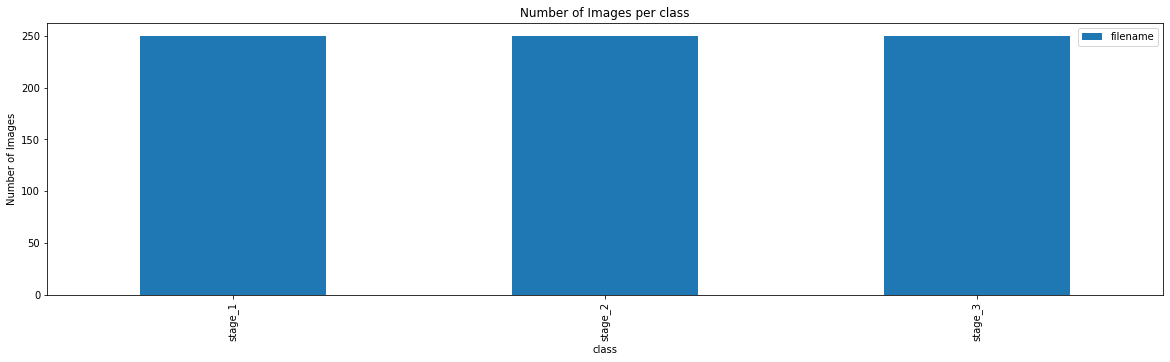

In [7]:
# visualizing the images count per class
data.groupby("class").count().plot(kind='bar', figsize=(20,5));
plt.ylabel('Number of Images');
plt.title('Number of Images per class');

#### Randomly ploting some data

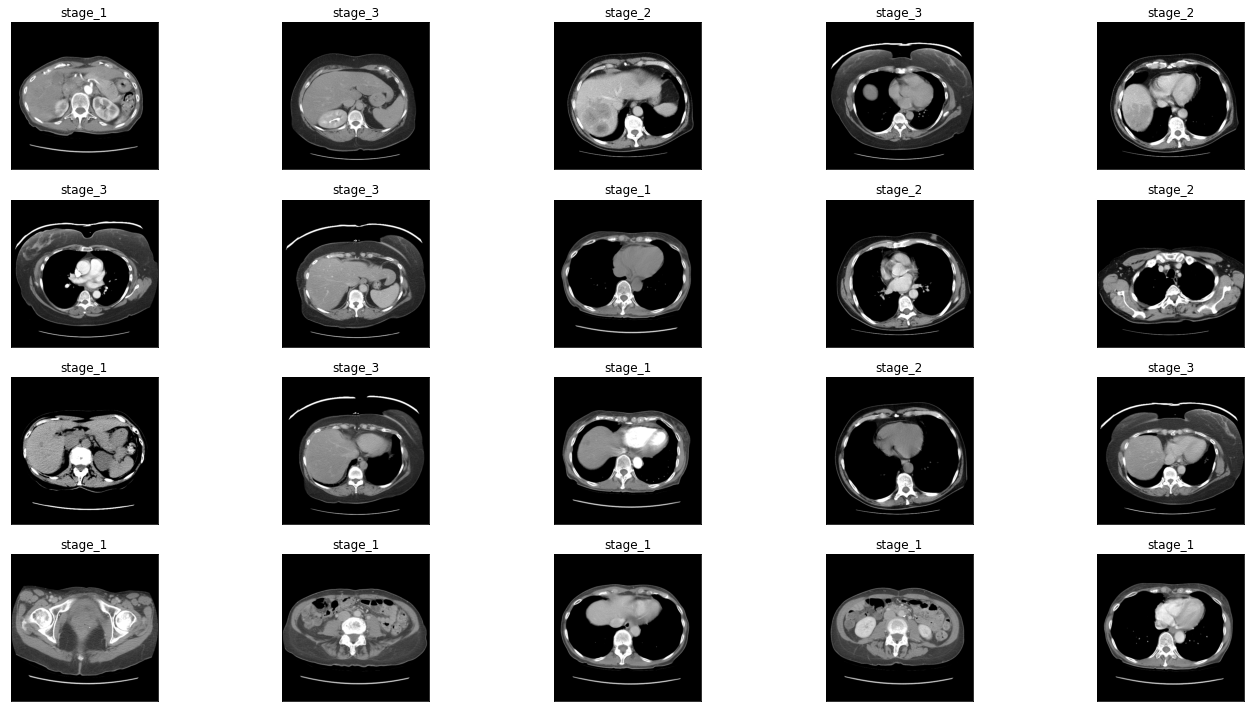

In [8]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = np.random.randint(0, len(data))
    img = plt.imread(data.filename.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(data['class'].iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [9]:
X = data['filename']
y = data['class']

### Spliting the data in Train and Test to be used by data Generator

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, xt,yt      =train_test_split(X,
                                             y,
                                             test_size=0.2,
                                             random_state=8)

In [11]:
# to confirm that train and test data has same classes
xt.nunique() == yt.nunique()

True

#### Separating images in train and test folders

In [12]:
!rm -r CancerData
os.mkdir('CancerData')

rm: cannot remove 'CancerData': No such file or directory


In [13]:
test_dir = "/content/CancerData/test/"
!rm -r {test_dir}
os.mkdir(test_dir)
for img_pth in X_val.tolist():
  dir = test_dir + img_pth.split('/')[-2]+'/'
  if not os.path.exists(dir):
    os.mkdir(dir)
  shutil.copy(img_pth,dir)

rm: cannot remove '/content/CancerData/test/': No such file or directory


In [14]:
train_dir = "/content/CancerData/train/"
!rm -r {train_dir}
os.mkdir(train_dir)
for img_pth in X_train.tolist():
  dir = train_dir + img_pth.split('/')[-2]+'/'
  if not os.path.exists(dir):
    os.mkdir(dir)
  shutil.copy(img_pth,dir)

rm: cannot remove '/content/CancerData/train/': No such file or directory


In [15]:
# How many images in each folder?
# Walk through test data directory and list number of files
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/CancerData/test/'.
There are 0 directories and 50 images in '/content/CancerData/test/stage_3_png'.
There are 0 directories and 53 images in '/content/CancerData/test/stage_1_png'.
There are 0 directories and 47 images in '/content/CancerData/test/stage_2_png'.


In [16]:
# How many images in each folder?
# Walk through train data directory and list number of files
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/CancerData/train/'.
There are 0 directories and 200 images in '/content/CancerData/train/stage_3_png'.
There are 0 directories and 197 images in '/content/CancerData/train/stage_1_png'.
There are 0 directories and 203 images in '/content/CancerData/train/stage_2_png'.


### Data Preprocessing
Now we have got our data ready for preprocessing. Now its the time to make preprocessing pipeline.


#### Reading the datda as expected by tensorflow.

In [17]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode="categorical",
                                                                  image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 600 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


## **Modelling**

#### Setting up the callbacks

In [18]:
# Create checkpoint callback to save model for later use
checkpoint_path = "1_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

### Creating and Compiling the model (Feature Extraction)

In [19]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

17235968/17225924 [==============================] - 1s 0us/step


In [20]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 global_average_pooling (Glo  (None, 1024)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 3)                 3075      
                                                                 
Total params: 3,231,939
Trainable params: 3,075
Non-trainable params: 3,228,864
_________________________________________________________________


In [21]:
%%time 
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_feature_extract= model.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.50 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
19/19 [==============================] - 14s 124ms/step - loss: 1.0797 - accuracy: 0.4933 - val_loss: 0.7153 - val_accuracy: 0.7031
Epoch 2/5
19/19 [==============================] - 2s 83ms/step - loss: 0.4904 - accuracy: 0.8900 - val_loss: 0.3618 - val_accuracy: 0.9531
Epoch 3/5
19/19 [==============================] - 2s 82ms/step - loss: 0.2669 - accuracy: 0.9783 - val_loss: 0.2477 - val_accuracy: 0.9844
Epoch 4/5
19/19 [==============================] - 2s 83ms/step - loss: 0.1730 - accuracy: 0.9933 - val_loss: 0.1657 - val_accuracy: 1.0000
Epoch 5/5
19/19 [==============================] - 2s 76ms/step - loss: 0.1233 - accuracy: 0.9983 - val_loss: 0.1187 - val_accuracy: 1.0000
CPU times: user 20.5 s, sys: 2.21 s, total: 22.8 s
Wall time: 23.6 s


#### Evaluation of Non fine tuned model

In [22]:
# Evaluate model - test data
%%time 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

5/5 [==============================] - 1s 155ms/step - loss: 0.1311 - accuracy: 1.0000
CPU times: user 1.01 s, sys: 49.8 ms, total: 1.06 s
Wall time: 1.3 s


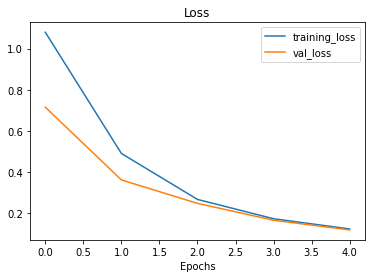

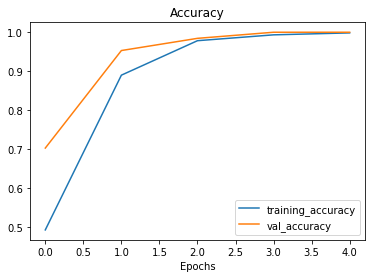

In [23]:
plot_loss_curves(history_feature_extract)

Ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

### Fine-tuning

In [24]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [25]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [26]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
mobilenet_1.00_224 True
global_average_pooling True
output_layer True


In [27]:
# Fine-tune for more epochs
fine_tune_epochs = 10 # model has already done some epochs, this is the total number of epochs we're after 

history_fine_tune = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.5 * len(test_data)), # validate on 50% of the test data
                              initial_epoch=history_feature_extract.epoch[-1]) # start from previous last epoch

Epoch 5/10
19/19 [==============================] - 5s 106ms/step - loss: 0.2882 - accuracy: 0.8733 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 6/10
19/19 [==============================] - 2s 80ms/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 7/10
19/19 [==============================] - 2s 79ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 8/10
19/19 [==============================] - 2s 77ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 9/10
19/19 [==============================] - 2s 77ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 10/10
19/19 [==============================] - 2s 79ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000


In [28]:
# Evaluate fine-tuned model on the whole test dataset
results_fine_tune = model.evaluate(test_data)
results_fine_tune

5/5 [==============================] - 0s 88ms/step - loss: 0.0045 - accuracy: 1.0000


[0.004466185346245766, 1.0]

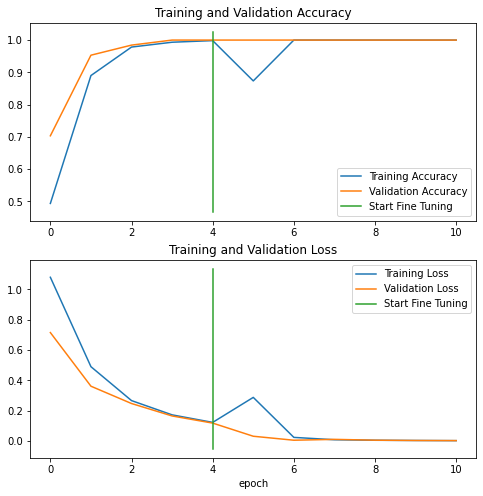

In [29]:
# compare both of the histories objects
compare_historys(original_history=history_feature_extract,
                 new_history=history_fine_tune,
                 initial_epochs=5)

#### Saving our trained model

In [30]:
# # Save model to drive so it can be used later 
# model.save("path")

## **Detailed Evaluation**

#### Predictions on test data using the model

In [31]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

5/5 [==============================] - 1s 90ms/step


In [32]:
# total predictions: should be equal to num of images in test set
len(pred_probs)

150

In [33]:
pred_probs.shape # containing an array for each image

(150, 3)

In [34]:
# lets see how they look like
pred_probs[:2]

array([[9.9964845e-01, 3.3852356e-04, 1.2976166e-05],
       [9.9508518e-01, 3.3334515e-03, 1.5814253e-03]], dtype=float32)

In [35]:
#Now Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [36]:
pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Unbatchyfy the test data to get actual labels

In [37]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)


In [38]:
y_labels[:10] # how they look like now

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [39]:
len(y_labels) # same as preds

150

#### Accuracy score

In [40]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_labels, pred_classes)
precision = precision_score(y_labels, pred_classes,average='weighted')
recall = recall_score(y_labels, pred_classes,average='weighted')
f1 = f1_score(y_labels, pred_classes, average='weighted')
print('accuracy:', accuracy, 'precision:', precision, 'recall:', recall, 'f1-score:', f1)

accuracy: 1.0 precision: 1.0 recall: 1.0 f1-score: 1.0


#### Confusion Matrix

In [41]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['stage_1_png', 'stage_2_png', 'stage_3_png']

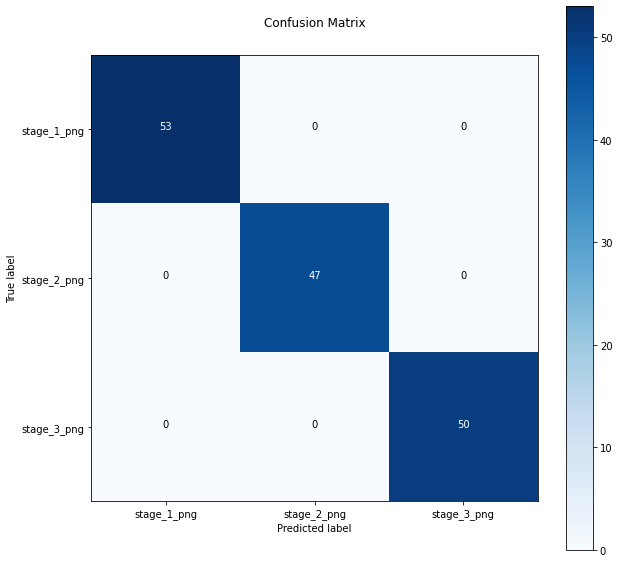

In [42]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=10,
                      norm=False,
                      savefig=True)

#### Classification Report

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



#### Visualizing the predictions on an image (unseen)

In [44]:
#preprocess test image
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img, 3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [45]:
# loading the image, mapping the labels and visualizing the results
filepath = '/content/CancerData/test/stage_3_png/S4 (1).png'
class_name = filepath.split('/')[-2]
img = load_and_prep_image(filepath, scale=False) 
pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
pred_class = class_names[pred_prob.argmax()] # find the predicted class 

In [46]:
pred_class

'stage_3_png'

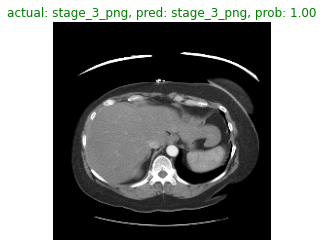

In [47]:
## visualizing
plt.imshow(img/255.)
if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
else:
    title_color = "r"
plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
plt.axis(False);